<h1>Galaxies, Stars and Quasars classification</h1>
The Dataset are made in this way:
<ul>
    <li>objid       = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS</li>
    <li>ra          = Right Ascension angle (at J2000 epoch)</li>
    <li>dec         = Declination angle (at J2000 epoch)</li>
    <li>u           = Ultraviolet filter in the photometric system</li>
    <li>g           = Green filter in the photometric system</li>
    <li>r           = Red filter in the photometric system</li>
    <li>i           = Near Infrared filter in the photometric system</li>
    <li>z           = Infrared filter in the photometric system</li>
    <li>run         = Run Number used to identify the specific scan</li>
    <li>rereun      = Rerun Number to specify how the image was processed</li>
    <li>camcol      = Camera column to identify the scanline within the run</li>
    <li>field       = Field number to identify each field</li>
    <li>specobjid   = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)</li>
    <li>redshift    = redshift value based on the increase in wavelength</li>
    <li>plate       = plate ID, identifies each plate in SDSS</li>
    <li>mjd         = Modified Julian Date, used to indicate when a given piece of SDSS data was taken</li>
    <li>fiberid     = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation</li>
    <li>class       = object class (galaxy, star or quasar object)</li>
</ul>

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression, f_regression, SelectKBest
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from scipy.stats import pearsonr
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import pickle
from sklearn.model_selection import StratifiedKFold


Let's start loading the dataset in a dataframe

In [2]:
# dfStars = pd.read_csv('Skyserver_12_15_2020 3 45 07 AM.csv', na_values="?")
dfStars = pd.read_csv('FileCSV/star_classification.csv', na_values="?")
dfStars

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.237679e+18,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,7778,301,2,581,1.055431e+19,GALAXY,0.000000,9374,57749,438
99996,1.237679e+18,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,7917,301,1,289,8.586351e+18,GALAXY,0.404895,7626,56934,866
99997,1.237668e+18,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,5314,301,4,308,3.112008e+18,GALAXY,0.143366,2764,54535,74
99998,1.237661e+18,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,3650,301,4,131,7.601080e+18,GALAXY,0.455040,6751,56368,470


In [ ]:
dfStars.head().T

Here I check the distribution of the Labeled-Class

In [ ]:
dfStars['class'].value_counts()

In [ ]:
fig,axes = plt.subplots(1, 1, figsize=(5,5), sharey=True)
sns.countplot(x='class',data = dfStars, ax = axes, order = dfStars['class'].value_counts().index)
plt.show()

Check same info about the feature of the DataSet

In [ ]:
dfStars.drop('class', axis=1).describe()

In [ ]:
dfStars.info()

Check for Nan or Null value

In [ ]:
dfStars.isna().sum(axis=0)

Checking if there is some duplicate

In [ ]:
dfStars[dfStars.duplicated(keep=False)]

<h1>Encoding of the classed-class</h1>

In [3]:
# Normalize the classed-class with numerical data
dfStars['class'] = dfStars['class'].replace({'GALAXY': 0, 'STAR': 1, 'QSO': 2})

In [ ]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(dfStars.drop(['class'], axis = 1).corr(), annot=True, linewidths=.5, fmt='.2f', ax=ax, annot_kws={'fontsize': 8})
plt.show()

<h3>Distribution of each useful attribute divided by class</h3>
This distribution will be useful for make a comparison with the dataset after the rebalance part

In [ ]:
dfStars['last'] = 0
for att in dfStars.drop(['objid','ra','run','rerun','camcol','field','fiberid', 'class'], axis = 1).columns[:-1]:
    dfStars.hist(column=att, by='class', bins=7, figsize=(15,4), layout = (1,3))
    print(att)
    plt.show()
dfStars.drop(['last'], axis=1, inplace=True)


In [ ]:
for att in dfStars.drop(['objid', 'ra', 'run','rerun','camcol','field','fiberid', 'class'], axis = 1).columns[:-1]:
    sns.boxplot(x='class', y=att, data=dfStars)
    plt.show()

Show the relationship between all pairs of variables into the dataset

In [ ]:
sns.pairplot(data=dfStars, hue="class")

<h1>Split the dataset in training set and test set.</h1>

In [4]:
X = dfStars.drop('class', axis=1)
y = dfStars['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print('Shape of the train and test set')
print(X_train.shape) # type: ignore
print(X_test.shape) # type: ignore
print()
print('Distribution of the labeled-classes')  
print()
print("Training Set")
print(pd.Series(y_train).value_counts())
print()
print("Test Set")
print(pd.Series(y_test).value_counts())

Shape of the train and test set
(70000, 17)
(30000, 17)

Distribution of the labeled-classes

Training Set
0    41636
1    15044
2    13320
Name: class, dtype: int64

Test Set
0    17809
1     6550
2     5641
Name: class, dtype: int64


<h1>Feature Selection</h1>

In the following cell I perform SelectKBest wit f_regression with k=10, for select the best feature

In [5]:
# Create an object SelectKBest with the value of k
selector = SelectKBest(score_func=f_regression, k=10)

# Fit
X_selected = selector.fit_transform(X_train, y_train)

dfKBest = pd.DataFrame(selector.scores_, columns=['Score'])
dfKBest.index = ['objid','ra','dec','u','g','r','i','z','run','rerun','camcol','field','specobjid','redshift','plate','mjd','fiberid'] # type: ignore
display(dfKBest.sort_values(by='Score', ascending=False))
print()
print("Features selected:")
print(X_train.columns[selector.get_support()]) # type: ignore

,Score
redshift,28655.952271
z,9269.757834
i,6208.254359
u,3823.399010
plate,3402.130505
specobjid,3402.116179
mjd,3109.637519
r,1659.220666
g,305.125852
dec,218.452539



Features selected:
Index(['dec', 'u', 'g', 'r', 'i', 'z', 'specobjid', 'redshift', 'plate',
       'mjd'],
      dtype='object')


<h3>Delete Features</h3>
Drop all features rated lower than 10

In [6]:
X_train.drop(['objid', 'ra', 'run','rerun','camcol','field','fiberid'], axis = 1, inplace=True) # type: ignore

<h1>Outlier Detection</h1>

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import LocalOutlierFactor

# definisci la lista di valori da provare per n_neighbors e contamination
param_grid = {'n_neighbors': [1, 5, 10, 15, 20], 'contamination': [0.1, 0.2, 0.3, 0.01, 0.02, 0.05, 'auto']}

# crea l'oggetto LocalOutlierFactor
lof = LocalOutlierFactor(novelty=True)

# crea l'oggetto GridSearchCV
grid_search = GridSearchCV(lof, param_grid, cv=10, scoring='accuracy')

# estrai le feature dal DataFrame
X = X_train[['u', 'g', 'r', 'i', 'z', 'redshift', 'plate']] # type: ignore

grid_search.fit(X, y_train)
print("The best parameters for Galaxy are:", grid_search.best_params_)

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import GridSearchCV

print(X_train.shape)

# crea l'oggetto LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=10, contamination=0.01)

# Xp = X_train[['u', 'g', 'r', 'i', 'z', 'redshift', 'plate']]
outliers = lof.fit_predict(X_train, y_train)

X_filtered = X_train[outliers == 1]
y_filtered = y_train[outliers == 1]
print(X_filtered.shape)

# X_train = X_filtered
# y_train = y_filtered


In [8]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import GridSearchCV

df_merged = pd.concat([X_train, y_train], axis=1) # type: ignore
print(df_merged.shape)

# crea l'oggetto LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=10, contamination=0.01)

# seleziona il DataFrame per la classe GALAXY 
# estrai le feature dal DataFrame 
# ottieni gli outlier con il metodo fit_predict
df_galaxy = df_merged[df_merged['class'] == 0]
XX = df_galaxy[['u', 'g', 'r', 'i', 'z', 'redshift', 'plate']]
outliers_galaxy = lof.fit_predict(XX)

df_star = df_merged[df_merged['class'] == 1]
XX = df_star[['u', 'g', 'r', 'i', 'z', 'redshift', 'plate']]
outliers_star = lof.fit_predict(XX)

df_qso = df_merged[df_merged['class'] == 2]
XX = df_qso[['u', 'g', 'r', 'i', 'z', 'redshift', 'plate']]
outliers_qso = lof.fit_predict(XX)

df_filtered_galaxy = df_galaxy[outliers_galaxy == 1]
df_filtered_star = df_star[outliers_star == 1]
df_filtered_qso = df_qso[outliers_qso == 1]

print(f"Galaxy: {df_galaxy.shape} ---> {df_filtered_galaxy.shape}")
print(f"Star: {df_star.shape} ---> {df_filtered_star.shape}")
print(f"QSO: {df_qso.shape} ---> {df_filtered_qso.shape}")

df_after_outlier = pd.concat([df_filtered_galaxy, df_filtered_star, df_filtered_qso])
print(df_after_outlier.shape)

(70000, 11)
Galaxy: (41636, 11) ---> (41219, 11)
Star: (15044, 11) ---> (14893, 11)
QSO: (13320, 11) ---> (13186, 11)
(69298, 11)


In [9]:
X_train = df_after_outlier.drop('class', axis=1)
y_train = df_after_outlier['class']

In [ ]:
df_merged = pd.concat([X_filtered, y_filtered], axis=1) # type: ignore
for att in df_merged.columns[:-1]:  # type: ignore
    sns.boxplot(x='class', y=att, data=df_merged)
    plt.show()

<h1>Rebalance Dataset</h1>
I add features into the two minority classes (STAR, QSO) until they reach the class with the higer number of examble (GALAXY). <br>
In the following snip of code I implement an over sampling without replacement, using SMOTE.

In [10]:
# using oversampling with SMOTE to deal with imbalanced data
sm = SMOTE(random_state=42)
X_train_after_balancing, y_train_after_balancing = sm.fit_resample(X_train, y_train) # type: ignore

print(X_train_after_balancing.shape) # type: ignore
y_train_after_balancing.value_counts() # type: ignore

(123657, 10)


0    41219
1    41219
2    41219
Name: class, dtype: int64

Now I analyse the distribution of each attribute, after the rebalancing of the datasets

In [ ]:
df_merged = pd.concat([X_train_after_balancing, y_train_after_balancing], axis=1)
for att in df_merged.columns[:-1]:  # type: ignore
    df_merged.hist(column=att, by='class', bins = 7, figsize=(15,4),layout = (1,3), color='r')
    print(att)
    plt.show()

In [ ]:
df_merged = pd.concat([X_train_after_balancing, y_train_after_balancing], axis=1)
for att in df_merged.columns[:-1]:  # type: ignore
    sns.boxplot(x='class', y=att, data=df_merged)
    plt.show()

<h1 style="font-weight: bold">CLASSIFICATION</h1>

In [11]:
# Split the dataset into features and classs
X_train_class = X_train_after_balancing
y_train_class = y_train_after_balancing
X_train_class.shape, y_train_class.shape

((123657, 10), (123657,))

In [13]:
X_test_drop = X_test.drop(['objid', 'ra', 'run', 'rerun', 'camcol', 'field', 'fiberid'], axis = 1) # type: ignore

<h2>KNeighborsClassifier</h2>
I tried to perform KNN with different k, for understand which is the best. <br>
I decided to use the euclidean and the manhattan distance, for make a comparison

In [ ]:
k_neighbors = 100
metrics = ['euclidean', 'manhattan']

accuracy_total = []
for k in range(1, k_neighbors+1, 1):
    accuracy_k = []
    for metric in metrics:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        knn.fit(X_train_class, y_train_class)
        y_predKNN = knn.predict(X_test_drop)
        accuracy = accuracy_score(y_test, y_predKNN)
        accuracy_k.append(accuracy)
        # print(f"For metric = {metric} and k = {k}:      ACCURACY = {accuracy}")
    accuracy_total.append(accuracy_k)

accuracy_df = pd.DataFrame(np.array(accuracy_total), columns=metrics)
k_df = pd.DataFrame([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100], columns=['k'])
accuracy_join= k_df.join(accuracy_df)

The following snip of code shows us the trend of the KNN's accuracy for the euclidean and manhattan distance.<br> 
The graph for each distance it's almost the same. But the accurasy reach just the 67% in the peak, for k = 3.

In [ ]:
plt.plot(accuracy_join['k'], accuracy_join['euclidean'], label='euclidean')
plt.plot(accuracy_join['k'], accuracy_join['manhattan'], label='manhattan')

plt.legend()
plt.xlabel('k')
plt.ylabel('accuracy score')
plt.show()

In [ ]:
accuracy_ed = []
accuracy_md = []

for i in range(k_neighbors):
    accuracy_ed.append(accuracy_total[i][0])
    accuracy_md.append(accuracy_total[i][1])

max_index = max(enumerate(accuracy_ed), key=lambda x: x[1])[0]
print(f"Euclidean Distance: The value of k with the higher accuracy is {max_index}. Accurasy = {accuracy_ed[max_index]}")

max_index = max(enumerate(accuracy_md), key=lambda x: x[1])[0]
print(f"Manhattan Distance: The value of k with the higher accuracy is: {max_index}. Accurasy = {accuracy_md[max_index]}")

accuracyKNN = accuracy_md[max_index]

Cross-validation scores: [0.7019 0.694  0.6857 0.693  0.6958 0.6948 0.6973 0.6922 0.6917 0.6965]
Mean score: 0.69429


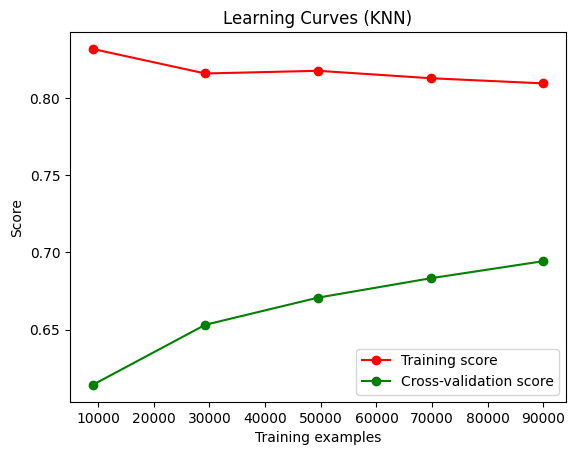

In [15]:
knn = KNeighborsClassifier(n_neighbors=3, metric='manhattan')
knn.fit(X_train_class, y_train_class)
y_predKNN = knn.predict(X_test_drop)

# Utilizza la cross-validation per valutare l'accuratezza del modello
skf = StratifiedKFold(10, shuffle = True, random_state = 21)
scores = cross_val_score(knn, X, y, cv=skf)

# Stampa i risultati della cross-validation
print(f"Cross-validation scores: {scores}")
print(f"Mean score: { scores.mean()}")

# Disegna la curva di apprendimento del modello
train_sizes, train_scores, test_scores = learning_curve(knn, X, y, cv=skf) # type: ignore

plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', color='r', label="Training score")
plt.plot(train_sizes, test_scores.mean(axis=1), 'o-', color='g', label="Cross-validation score")

plt.title("Learning Curves (KNN)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

In [ ]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier

# Crea un oggetto KFold con 10 fold e una semina casuale
kfold = KFold(n_splits=10, shuffle=True, random_state=0)

scores = []

# Esegui il loop sui fold
for train_index, test_index in kfold.split(X):
    # Seleziona il dataset di training e di test per il fold corrente
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Addestra il modello KNN sui dati di training
    knn.fit(X_train, y_train)

    # Valuta il modello KNN sui dati di test
    score = knn.score(X_test, y_test)

    # Aggiungi il punteggio alla lista
    scores.append(score)

# Calcola la media dei punteggi di validazione
mean_score = np.mean(scores)
print("La media dei punteggi di validazione è:", mean_score)

<h2>Decision Tree</h2>

In [16]:
# Create the model
dtc = DecisionTreeClassifier()

# Fit the model
dtc = dtc.fit(X_train_class, y_train_class)
y_predDT = dtc.predict(X_test_drop)

# Check the accuracy
accuracyDT = accuracy_score(y_test, y_predDT)
print(f"Accuracy: {accuracyDT:.2f}")

Accuracy: 0.96


Cross-validation scores: [0.967  0.9637 0.9645 0.9669 0.9651 0.9651 0.9639 0.9647 0.9641 0.962 ]
Mean score: 0.9646999999999999


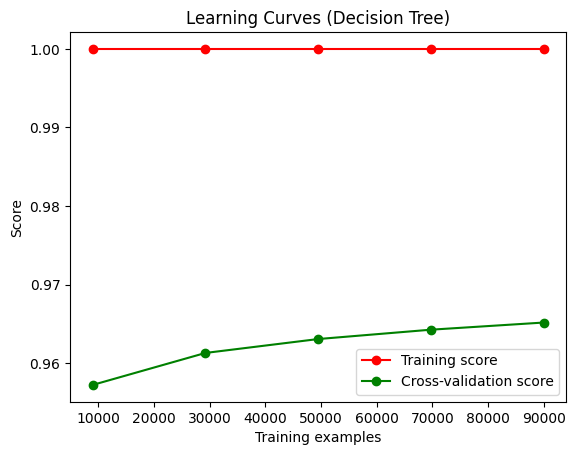

In [17]:
# Utilizza la cross-validation per valutare l'accuratezza del modello
skf = StratifiedKFold(10, shuffle = True, random_state = 21)
scores = cross_val_score(dtc, X, y, cv=skf)

# Stampa i risultati della cross-validation
print(f"Cross-validation scores: {scores}")
print(f"Mean score: { scores.mean()}")

# Disegna la curva di apprendimento del modello
train_sizes, train_scores, test_scores = learning_curve(dtc, X, y, cv=skf) # type: ignore

plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', color='r', label="Training score")
plt.plot(train_sizes, test_scores.mean(axis=1), 'o-', color='g', label="Cross-validation score")

plt.title("Learning Curves (Decision Tree)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

<h1>Random Forest</h1>

In [18]:
# Create the model
rf = RandomForestClassifier(criterion="entropy")

# Fit the model
rf.fit(X_train_class, y_train_class)

# Check the accuracy
y_predRF = rf.predict(X_test_drop)
accuracyRF = accuracy_score(y_test, y_predRF)
print(f"Accuracy: {accuracyRF:.2f}")

Accuracy: 0.98


Cross-Validation for Random Forest

Cross-validation scores: [0.9802 0.9777 0.9772 0.98   0.9774 0.9783 0.9782 0.9806 0.9779 0.9787]
Mean score: 0.97862


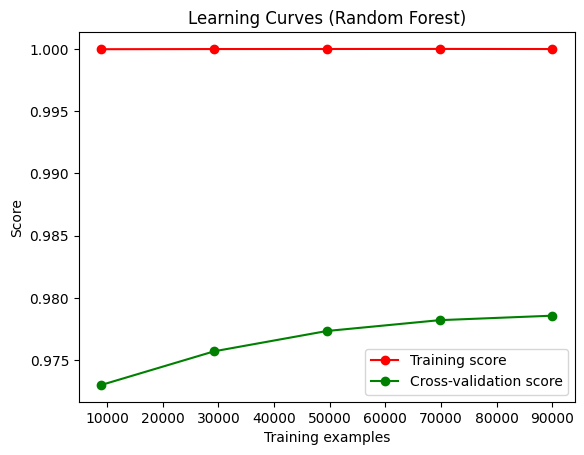

In [19]:
# Utilizza la cross-validation per valutare l'accuratezza del modello
skf = StratifiedKFold(10, shuffle = True, random_state = 21)
scores = cross_val_score(rf, X, y, cv=skf)

# Stampa i risultati della cross-validation
print(f"Cross-validation scores: {scores}")
print(f"Mean score: { scores.mean()}")

# Disegna la curva di apprendimento del modello
train_sizes, train_scores, test_scores = learning_curve(rf, X, y, cv=skf) # type: ignore

plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', color='r', label="Training score")
plt.plot(train_sizes, test_scores.mean(axis=1), 'o-', color='g', label="Cross-validation score")

plt.title("Learning Curves (Random Forest)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

<h2>Bayesian Classifier</h2>

In [20]:
from sklearn.naive_bayes import GaussianNB
from scipy.stats import pearsonr

# Create the model
gnb = GaussianNB()

# Fit the model
gnb.fit(X_train_class, y_train_class)

# Check the accuracy
y_predBC = gnb.predict(X_test_drop)
accuracyBC = accuracy_score(y_test, y_predBC)
print(f"Accuracy: {accuracyBC:.2f}")

Accuracy: 0.30


Cross-validation scores: [0.6038 0.6052 0.6014 0.6006 0.599  0.6008 0.6053 0.6004 0.5985 0.6024]
Mean score: 0.6017399999999999


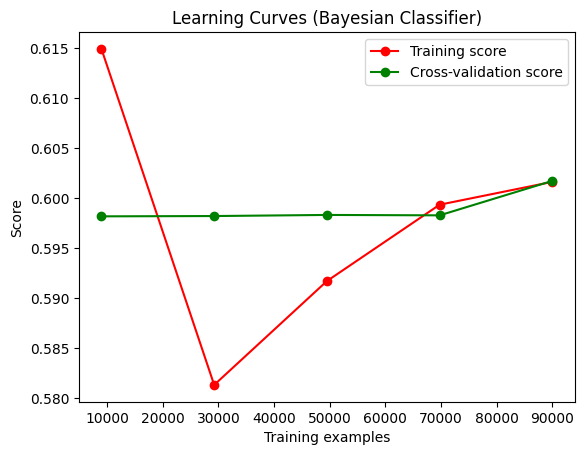

In [21]:
# Utilizza la cross-validation per valutare l'accuratezza del modello
skf = StratifiedKFold(10, shuffle = True, random_state = 21)
scores = cross_val_score(gnb, X, y, cv=skf)

# Stampa i risultati della cross-validation
print(f"Cross-validation scores: {scores}")
print(f"Mean score: { scores.mean()}")

# Disegna la curva di apprendimento del modello
train_sizes, train_scores, test_scores = learning_curve(gnb, X, y, cv=skf) # type: ignore

plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', color='r', label="Training score")
plt.plot(train_sizes, test_scores.mean(axis=1), 'o-', color='g', label="Cross-validation score")

plt.title("Learning Curves (Bayesian Classifier)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

<h3>ACCURACY</h3>
Now we will analize the accuracy of all the tried classifier.<br>
We can note that the best algorithm is Random Forest


In [ ]:
print(f"Accuracy of Random Forest: {accuracyRF:.2f}")
print(f"Accuracy of Decision Tree: {accuracyDT:.2f}")
print(f"Accuracy of KNN: {accuracyKNN:.2f}")
print(f"Accuracy of Bayesian Classifier: {accuracyBC:.2f}")

In [ ]:
print('Train Sizes:')
print(train_sizes)
print()
print('Train Scores:')
print(train_scores) 
print()
print('Test Scores:')
for i in range(5):
    print(test_scores[i])
    print(f'Mean: {test_scores[i].mean()}')

Here I compute the Confusion Matrix for the Random Forest algorithm


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_predRF)

from yellowbrick.classifier import ConfusionMatrix
rf_cm = ConfusionMatrix(rf, classes=['GALAXY','STAR','QSO'])

rf_cm.fit(X_train_class, y_train_class)
rf_cm.score(X_test_drop, y_test)
rf_cm.show()

Compute **Accuracy**, **Sensitivity**, **Specificity**, **Precision** and **Recall** form the Confusion Matrix

In [ ]:
# Estraiamo gli elementi della confusion matrix che ci serviranno per calcolare le metriche
tp0, tp1, tp2 = confusion_matrix[0, 0], confusion_matrix[1, 1], confusion_matrix[2, 2]
fn0, fn1, fn2 = confusion_matrix[0, 1] + confusion_matrix[0, 2], confusion_matrix[1, 0] + confusion_matrix[1, 2], confusion_matrix[2, 0] + confusion_matrix[2, 1]
fp0, fp1, fp2 = confusion_matrix[1, 0] + confusion_matrix[2, 0], confusion_matrix[0, 1] + confusion_matrix[2, 1], confusion_matrix[0, 2] + confusion_matrix[1, 2]
tn0 = confusion_matrix[1, 1] + confusion_matrix[1, 2] + confusion_matrix[2, 1] + confusion_matrix[2, 2]
tn1 = confusion_matrix[0, 0] + confusion_matrix[0, 2] + confusion_matrix[2, 0] + confusion_matrix[2, 2]
tn2 = confusion_matrix[0, 0] + confusion_matrix[0, 1] + confusion_matrix[1, 0] + confusion_matrix[1, 1]

# Calcoliamo le metriche
accuracy0 = (tp0 + tn0)/confusion_matrix.sum()
accuracy1 = (tp1 + tn1)/confusion_matrix.sum()
accuracy2 = (tp2 + tn2)/confusion_matrix.sum()
sensitivity0 = tp0 / (tp0 + fn0)
sensitivity1 = tp1 / (tp1 + fn1)
sensitivity2 = tp2 / (tp2 + fn2)
specificity0 = tn0 / (tn0 + fp0)
specificity1 = tn1 / (tn1 + fp1)
specificity2 = tn2 / (tn2 + fp2)
precision0 = tp0 / (tp0 + fp0)
precision1 = tp1 / (tp1 + fp1)
precision2 = tp2 / (tp2 + fp2)
recall0 = tp0 / (tp0 + fn0)
recall1 = tp1 / (tp1 + fn1)
recall2 = tp2 / (tp2 + fn2)
fMeasure0 = (2*recall0*precision0)/(recall0+precision0)
fMeasure1 = (2*recall1*precision1)/(recall1+precision1)
fMeasure2 = (2*recall2*precision2)/(recall2+precision2)


print(f"Accuracy (GALAXY): {accuracy0:.2f}")
print(f"Accuracy (STAR): {accuracy1:.2f}")
print(f"Accuracy (QUASAR): {accuracy2:.2f}")
print()
print(f"Sensitivity (GALAXY): {sensitivity0:.2f}")
print(f"Sensitivity (STAR): {sensitivity1:.2f}")
print(f"Sensitivity (QUASAR): {sensitivity2:.2f}")
print()
print(f"Specificity (GALAXY): {specificity0:.2f}")
print(f"Specificity (STAR): {specificity1:.2f}")
print(f"Specificity (QUASAR): {specificity2:.2f}")
print()
print(f"Precision (GALAXY): {precision0:.2f}")
print(f"Precision (STAR): {precision1:.2f}")
print(f"Precision (QUASAR): {precision2:.2f}")
print()
print(f"Recall (GALAXY): {recall0:.2f}")
print(f"Recall (STAR): {recall1:.2f}")
print(f"Recall (QUASAR): {recall2:.2f}")
print()
print(f"F Measure (GALAXY): {fMeasure0:.2f}")
print(f"F Measure (STAR): {fMeasure1:.2f}")
print(f"F Measure (QUASAR): {fMeasure2:.2f}")

<h1 style="font-weight: bold">Save The Model<h1>

<p style="size: 12pt">I'll save the model of Random Forest in a file, for using them in an external application</p>

In [ ]:
with open('starClassificationApp/model.pkl', 'wb') as f:
    pickle.dump(rf, f)